In [1]:
%matplotlib inline

In [2]:
import numpy
import scipy.interpolate
import scipy.integrate

import matplotlib.pyplot as mpl

In [3]:
# Parameters for plot attributes
mpl.rc("xtick", labelsize="large")
mpl.rc("ytick", labelsize="large")
mpl.rc("axes", labelsize="xx-large")
mpl.rc("axes", titlesize="xx-large")
mpl.rc("figure", figsize=(8,8))

# Calculating the Magnetic Field with the Biot-Savart Law
According to the Biot-Savart law, 
$$ \vec{B}(\vec{r})=\frac{\mu_{0}I}{4\pi}\int\frac{\mathrm{d}\vec{\ell}\ '\times\left(\vec{r}-\vec{r}\ '\right)}{\left\vert \vec{r}-\vec{r}\ '\right\vert ^{3}}. $$

For a curve parameterized as $ \vec{\ell} = \left\lbrack x(t), y(t), z(t) \right\rbrack $, we can express the differential element as
$$ \mathrm{d}\vec{\ell} = \left\lbrack \frac{\mathrm{d}x}{\mathrm{d}t}, \frac{\mathrm{d}y}{\mathrm{d}t}, \frac{\mathrm{d}z}{\mathrm{d}t} \right\rbrack \mathrm{d}t. $$

It is convenient to let this parameter $t$ run from $0$ (at the beginning point of the curve) to $1$ (at the ending point of the curve).  

In [4]:
# Constants
mu0 = numpy.pi * 4.0E-7
Ic = 1.0   # current, in Amps

In [5]:
# the calculation mesh
NX = 1
NY = 20
NZ = 20
class Mesh:
    def __init__(self, NX, NY, NZ):
        self.minx = 0.0
        self.maxx = 0.0
        self.miny = -2.0
        self.maxy = 2.0
        self.minz = -2.0
        self.maxz = 2.0
        self.xarr = numpy.linspace(self.minx, self.maxx, NX, endpoint=False)
        self.yarr = numpy.linspace(self.miny, self.maxy, NY, endpoint=False)
        self.zarr = numpy.linspace(self.minz, self.maxz, NZ, endpoint=False)
        
    def calc_vecR(self, ix, iy, iz):
        rx = self.xarr[ix]
        ry = self.yarr[iy]
        rz = self.zarr[iz]
        return numpy.array([rx, ry, rz])
    
mesh = Mesh(NX, NY, NZ)
        

In [6]:
# define the integration kernels, component-by-component
# arguments:
# t = parameter that specifies curve location
# vecL = array of the three splines x(t), y(t), z(t)
# vecR = array of the coordinates where the B field is being calculated
def kernelx(t, vecL, vecR):
    vL = numpy.array([vecL[0].derivatives(t), vecL[1].derivatives(t), vecL[2].derivatives(t)])
    vSep = vecR - vL[:,0]
    dL = vL[:,1]    # grabs the derivatives
    crossx = dL[1]*vSep[2] - dL[2]*vSep[1]
    return (crossx / numpy.sqrt(sum(vSep**2))**3)

def kernely(t, vecL, vecR):
    vL = numpy.array([vecL[0].derivatives(t), vecL[1].derivatives(t), vecL[2].derivatives(t)])
    vSep = vecR - vL[:,0]
    dL = vL[:,1]    # grabs the derivatives
    crossy = dL[2]*vSep[0] - dL[0]*vSep[2]
    return (crossy / numpy.sqrt(sum(vSep**2)) ** 3)

def kernelz(t, vecL, vecR):
    vL = numpy.array([vecL[0].derivatives(t), vecL[1].derivatives(t), vecL[2].derivatives(t)])
    vSep = vecR - vL[:,0]
    dL = vL[:,1]    # grabs the derivatives
    crossz = dL[0]*vSep[1] - dL[1]*vSep[0]
    return (crossz / numpy.sqrt(sum(vSep**2)) ** 3)

In [7]:
# now, to calculate the B field at each point on the grid
# arguments:
# vecL: the parameterized curve, with splines [x(t), y(t), z(t)]
# X, Y, Z: the x, y, and z grid points (as returned by a numpy.meshgrid)
# returns: the components of the vector field Bx, By, Bz at each point on the grid
def BiotSavart(vecL):
    # set up the X, Y, and Z grid
    B = numpy.zeros((NZ, NY, NX, 3))
    for iz in range(0,NZ):
        for iy in range(0,NY):
            for ix in range(0,NX):
                vecR = mesh.calc_vecR(ix,iy,iz)
                B[iz,iy,ix,0] = scipy.integrate.quad(kernelx, 0.0, 1.0, args=(vecL, vecR))[0]
                B[iz,iy,ix,1] = scipy.integrate.quad(kernely, 0.0, 1.0, args=(vecL, vecR))[0]
                B[iz,iy,ix,2] = scipy.integrate.quad(kernelz, 0.0, 1.0, args=(vecL, vecR))[0]
    return B*mu0*Ic/(4.0*numpy.pi)

In [8]:
# A simple function to compute the B field at the origin
def BAtOrigin(vecL):
    B = numpy.zeros(3)
    vecR = numpy.array([0.0, 0.0, 0.0])
    B[0] = scipy.integrate.quad(kernelx, 0.0, 1.0, args=(vecL, vecR))[0]
    B[1] = scipy.integrate.quad(kernely, 0.0, 1.0, args=(vecL, vecR))[0]
    B[2] = scipy.integrate.quad(kernelz, 0.0, 1.0, args=(vecL, vecR))[0]
    return B*mu0*Ic/(4.0*numpy.pi)

### Exercise 1


In [9]:
# a square loop
# These classes define a square loop by linear interpolation.
# As a design choice, the classes are patterned after the Scipy 
#      interpolation spline class.  
# For each vector component of $\vec{\ell}(t)$, define the functions:
#   - __init__: The class constructor sets the basic parameters.
#   - derivatives: returns both the value and the first derivative.
#   - __call__: convenience function to return just the value. 
class Square_x:
    def __init__(self):
        self.length = 1.0
        self.vertices = self.length*numpy.array([0.5, -0.5, -0.5, 0.5])
    def derivatives(self, t):
        if (t < 0.25):
            tp = (t) / 0.25
            vstart = 0
            vend = 1
        elif (t < 0.5):
            tp = (t-0.25) / 0.25
            vstart = 1
            vend = 2
        elif (t < 0.75):
            tp = (t-0.5) / 0.25
            vstart = 2
            vend = 3
        else:
            tp = (t-0.75) / 0.25
            vstart = 3
            vend = 0
        value = self.vertices[vstart] + tp*(self.vertices[vend] - self.vertices[vstart])
        der = 4.0 * (self.vertices[vend] - self.vertices[vstart])
        return [value, der]
    def __call__(self,t):
        value, der = self.derivatives(t)
        return value

class Square_y:
    def __init__(self):
        self.length = 1.0
        self.vertices = self.length*numpy.array([0.5, 0.5, -0.5, -0.5])
    def derivatives(self,t):
        if (t < 0.25):
            tp = (t) / 0.25
            vstart = 0
            vend = 1
        elif (t < 0.5):
            tp = (t-0.25) / 0.25
            vstart = 1
            vend = 2
        elif (t < 0.75):
            tp = (t-0.5) / 0.25
            vstart = 2
            vend = 3
        else:
            tp = (t-0.75) / 0.25
            vstart = 3
            vend = 0
        value = self.vertices[vstart] + tp*(self.vertices[vend] - self.vertices[vstart])
        der = 4.0 * (self.vertices[vend] - self.vertices[vstart])
        return [value, der]
    def __call__(self, t):
        value, der = self.derivatives(t)
        return value
    
class Square_z:
    def __init__(self):
        self.length = 1.0
        self.vertices = self.length*numpy.array([0.0, 0.0, 0.0, 0.0])
    def derivatives(self,t):
        #theta = 8.0 * numpy.pi * t
        value = 0.0
        der = 0.0
        return [value, der]
    def __call__(self, t):
        value, der = self.derivatives(t)
        return value
    
def SquareBAtOrigin():
    length = 1.0
    Bz = 2.0*numpy.sqrt(2.0)*mu0*Ic/(numpy.pi*length)
    return numpy.array([0.0, 0.0, Bz])

Pass your chosen curve $\vec{\ell}(t)$ to the BiotSavart function. 

In [10]:
#lx = line_x
#ly = line_y
#lz = line_z
lx = Square_x()
ly = Square_y()
lz = Square_z()

In [11]:
B = BiotSavart([lx,ly,lz])

In [12]:
# set up plotting grid
Y, Z = numpy.meshgrid(mesh.yarr, mesh.zarr)


//anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


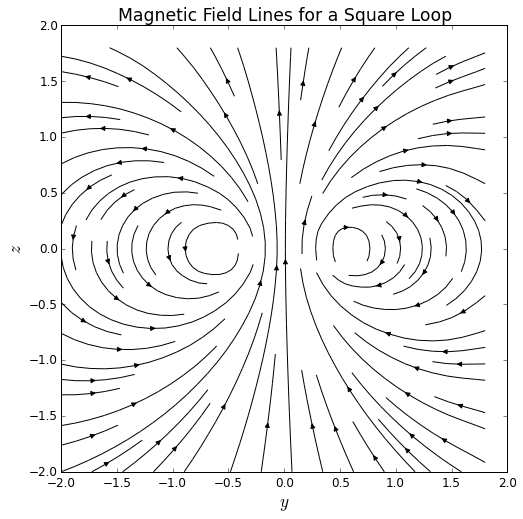

In [13]:
# vector plot of the magnetic field
mpl.streamplot(Y,Z, B[:,:,0,1], B[:,:,0,2], color="black")
mpl.xlabel("$y$")
mpl.ylabel("$z$")
mpl.title("Magnetic Field Lines for a Square Loop")

In [14]:
# Checking the numerics of the field at the origin
Bnum = BAtOrigin([lx, ly, lz])
Btrue = SquareBAtOrigin()
print("Bnum = ", Bnum)
print("Btrue = ", Btrue)
print("%err = ", 100.0*(Bnum - Btrue)/Btrue)

Bnum =  [  0.00000000e+00   0.00000000e+00   1.13137085e-06]
Btrue =  [  0.00000000e+00   0.00000000e+00   1.13137085e-06]
%err =  [             nan              nan  -1.87169607e-14]


//anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in true_divide


We see that there is excellent agreement between the numerical value of $\vec{B}$ at the origin, and the analytically expected value of $\vec{B}$.  

Because this is a case where the magnetic field component $B_z$ can be computed exactly along the $z$-axis, that comparison is plotted below.

The exact $B_z$ along the $z$-axis for a square loop with side length $a$ is
$$ B_z(z) = \frac{\mu_0 I a^2}{2\pi \left( z^2 + \frac{a^2}{4} \right) \sqrt{z^2 + \frac{a^2}{2}}}. $$

In [15]:
z = mesh.zarr
Bz_num = B[:,mesh.yarr==0,0,2]
Bz_true = mu0*Ic*(lx.length**2)/(2.0*numpy.pi*(z**2+(lx.length*.5)**2)*numpy.sqrt(z**2 + (lx.length**2)*.5))

(-2.0, 2.0)

//anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


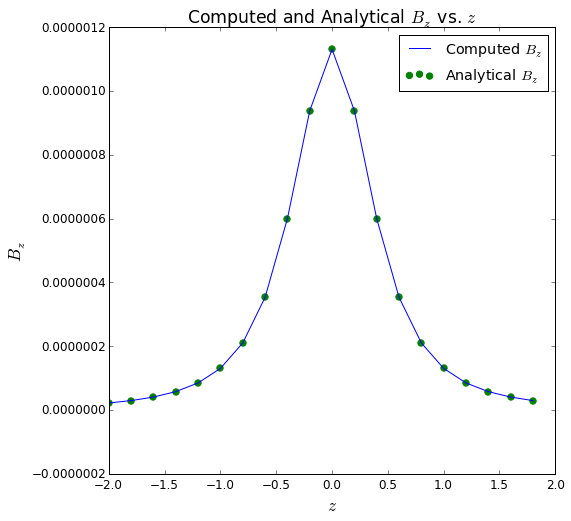

In [16]:
mpl.plot(z, Bz_num, label="Computed $B_z$")
mpl.scatter(z, Bz_true, label="Analytical $B_z$", marker="o", color="green", s=40)
mpl.xlabel("$z$")
mpl.ylabel("$B_z$")
mpl.title("Computed and Analytical $B_z$ vs. $z$")
mpl.legend(fontsize="x-large")
mpl.xlim(-2.0, 2.0)

We see excellent agreement between the computed $B_z$ and the exact $B_z$ on the $z$-axis.

### Extension

As an example of another wire geometry, a helical wire of radius $R$, height $L$, and $N$ turns is parameterized by 
$$ x(t) = R \cos\left( 2\pi N\,t \right), $$
$$ y(t) = R \sin\left( 2\pi N\,t \right), $$
$$ z(t) = Lt - \frac{1}{2}L. $$

In the example below, $R=1$, $N=80$, and $L=2.0$. 

In [18]:
# a helix
# These classes return the components of an exact helix
class Helix_x:
    Nturns = 80
    def derivatives(self, t):
        theta = self.Nturns * 2 * numpy.pi * t
        value = numpy.cos(theta)
        der = -self.Nturns * 2 * numpy.pi * numpy.sin(theta)
        return [value, der]
    def __call__(self,t):
        value, der = self.derivatives(t)
        return value

class Helix_y:
    Nturns = 80
    def derivatives(self,t):
        theta = self.Nturns * 2 * numpy.pi * t
        value = numpy.sin(theta)
        der = self.Nturns * 2 * numpy.pi * numpy.cos(theta)
        return [value, der]
    def __call__(self, t):
        value, der = self.derivatives(t)
        return value
    
class Helix_z:
    def derivatives(self,t):
        #theta = 8.0 * numpy.pi * t
        value = -1.0 + t*(2.0)
        der = 2.0
        return [value, der]
    def __call__(self, t):
        value, der = self.derivatives(t)
        return value


In [19]:
lx = Helix_x()
ly = Helix_y()
lz = Helix_z()

In [20]:
# Calculate B field for chosen wire geometry
B = BiotSavart([lx, ly, lz])

//anaconda/lib/python3.4/site-packages/scipy/integrate/quadpack.py:352: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
//anaconda/lib/python3.4/site-packages/scipy/integrate/quadpack.py:352: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


//anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


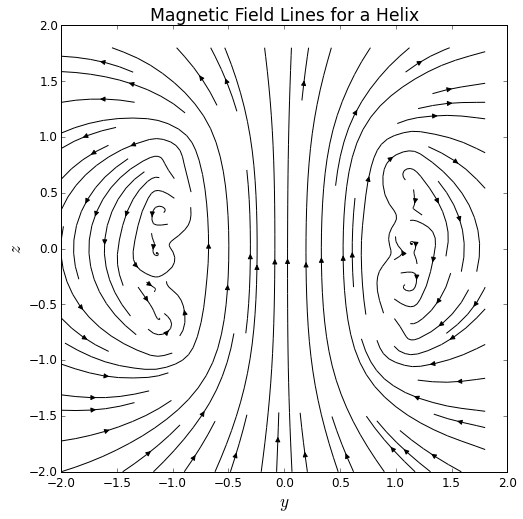

In [21]:
# vector plot of the magnetic field
mpl.streamplot(Y,Z, B[:,:,0,1], B[:,:,0,2], color="black")
mpl.xlabel("$y$")
mpl.ylabel("$z$")
mpl.title("Magnetic Field Lines for a Helix")

Because this helix is a simple approximation of a solenoid, we do see the magnetic field become nearly uniform inside the helix.  Outside of the helix, we see the magnetic field begin to resemble the magnetic field of a dipole, as it should.  